# CBOE Options data scrape
#### Note: This is valid as at Oct 9, 2020, future changes in CBOE website may render this program inoperable

- The CBOE options market statistics website has organized table format without protection, hence it is simple to scrape the tables using Pandas.
- Normally, I would convert them to Pandas dataframes, but in this case - since there are multiple tables, I thought the best way is to keep them all in dictionary format and save under one pickle file. Else I would have multiple tables that needed to be stored under separate .csv files.

In [1]:
# Importing libraries
import sys
import datetime
import time
import pandas as pd
import requests
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Adding in filepath and file location to facilitate load and save
filepath = r'C:\Users\path_to_your_file_location'
pickle_file = filepath + r'\CBOE_options_data.pkl'

# URL address of CBOE site where I would like to scrape
url_main = "https://markets.cboe.com/us/options/market_statistics/daily/?mkt=cone&dt="

Unfortunately, I have just recently started to scrape the website and I believe CBOE only keep the daily statistics for a maximum of 1 year. Beyond that those are erroneous data.

In [2]:
"""Scraping from CBOE website
- Enter the date from when to update the pickle file
Original file saved under pickle format, with dictionary format
First valid data = '2019-10-07     80497922.0'
"""
# Over here I have to manually incorporate the holidays so to delete them after downloading, for these dates the scraped data are incorrect
# This procedure works after the pickle file is created and run for subsequent times.
# For first time download, this module here will have error and exited - please continue to next module for the scraping.
# opt_out_days: Opting out public holidays
opt_out_days = ['2019-11-28', '2019-12-25', '2020-01-01', '2020-01-20', '2020-02-17', '2020-04-10',
                '2020-05-25', '2020-07-03', '2020-09-07']
weekdays =[]
scrapeDict ={}

def get(url):
    headers = {}
    resp = requests.get(url)
    if resp.ok:
        return resp.text

"""The following to check if there is existing pickle file already stored and available, program will
open it and continue to download from the last date.
If there is no existing file, program will continue with the download"""
# Loading in existing pickle file to merge with new data
try:
    infile = open(pickle_file,'rb')
    scrapeDict = pickle.load(infile)
    infile.close()
    print('CBOE file upload successful')
    print('Last date in the file:', list(scrapeDict.keys())[-1])
except:
    print('CBOE file not found, exiting program...')
    sys.exit()

# Getting rid of holidays listed under [opt_out_days]
print(len(scrapeDict.keys()))

for i in opt_out_days:
    try: 
        del scrapeDict[datetime.datetime.strptime(i,'%Y-%m-%d').date()]
    except KeyError:
        continue
print('Adjusted for opt-out-days:', len(scrapeDict.keys())) 

CBOE file upload successful
Last date in the file: 2020-09-23
334
Adjusted for opt-out-days: 334


In [3]:
"""This part is to scrape from CBOE website and save the file"""
inputStartDate = input('Enter starting date (YYYYMMDD) or <enter> for the last date in file : ')
if inputStartDate=='':
    start_date = list(scrapeDict.keys())[-1]
else:
    start_date = datetime.date(int(inputStartDate[:4]), int(inputStartDate[4:6]), int(inputStartDate[6:]))
end_date = datetime.date.today()
delta = datetime.timedelta(days=1)

run_date=start_date
while run_date < end_date:
    if run_date.weekday() not in [5,6]: #ie. Mon-Fri only
        weekdays.append(run_date)
    run_date += delta

print('Running:') 
for get_date in weekdays:
    html_date = datetime.datetime.strftime(get_date, '%Y-%m-%d')
    data = get(url_main+html_date)
    # As I mentioned above this is an easy site, I can just use Pandas read_html to extract the tables efficiently
    scrapeDict[get_date] = pd.read_html(data)
    print(get_date, end='|')
    # Putting in random pauses so not to overwhelm the website and got blacklisted and banned
    time.sleep(round(random.random()*3,1))

outfile = open(pickle_file,'wb')
pickle.dump(scrapeDict,outfile)
outfile.close()
print('Done!')

Enter starting date (YYYYMMDD) or <enter> for the last date in file :  


Running:
2020-09-23|2020-09-24|2020-09-25|2020-09-28|2020-09-29|2020-09-30|2020-10-01|2020-10-02|2020-10-05|2020-10-06|2020-10-07|2020-10-08|

### Data analysis section

In [20]:
"""Here we just get a look of how the tables are stacked up"""
pd.read_html(data)

[                                       RATIOS  RATIOS.1
 0                        TOTAL PUT/CALL RATIO      0.80
 1                        INDEX PUT/CALL RATIO      2.19
 2     EXCHANGE TRADED PRODUCTS PUT/CALL RATIO      1.02
 3                       EQUITY PUT/CALL RATIO      0.39
 4  CBOE VOLATILITY INDEX (VIX) PUT/CALL RATIO      3.02
 5                   SPX + SPXW PUT/CALL RATIO      1.81
 6                          OEX PUT/CALL RATIO      1.71,
   SUM OF ALL PRODUCTS SUM OF ALL PRODUCTS.1 SUM OF ALL PRODUCTS.2  \
 0                 NaN                  CALL                   PUT   
 1              VOLUME               2428558               1936445   
 2       OPEN INTEREST             199229542             170371643   
 
   SUM OF ALL PRODUCTS.3  
 0                 TOTAL  
 1               4365003  
 2             369601185  ,
    INDEX OPTIONS INDEX OPTIONS.1 INDEX OPTIONS.2 INDEX OPTIONS.3
 0            NaN            CALL             PUT           TOTAL
 1         VOLUME   

In [9]:
"""Getting a clearer view from below: 8 tables in all"""
# Get Table list
lastDate = list(scrapeDict.keys())[-1]  # get the last date on the file
for table in range(len(scrapeDict[lastDate])):
    print(table, scrapeDict[lastDate][table].columns[0])


0 RATIOS
1 SUM OF ALL PRODUCTS
2 INDEX OPTIONS
3 EXCHANGE TRADED PRODUCTS
4 EQUITY OPTIONS
5 CBOE VOLATILITY INDEX (VIX)
6 SPX + SPXW
7 OEX


In [10]:
"""How each table looks like - All in same organized format, hence this makes analysing the data much easier
Row 1 for volume, 2 for Open Interest.
Column 1 for Call options, 2 for Put options and 3 for Total"""
table=4
scrapeDict[lastDate][table]

,EQUITY OPTIONS,EQUITY OPTIONS.1,EQUITY OPTIONS.2,EQUITY OPTIONS.3
0,NaN,CALL,PUT,TOTAL
1,VOLUME,1578128,610765,2188893
2,OPEN INTEREST,140326927,99353318,239680245


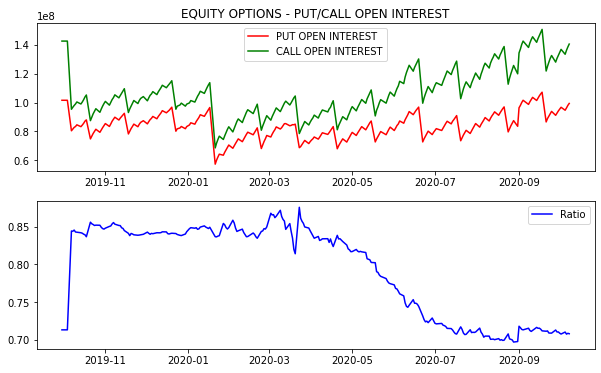

In [13]:
"""Plotting the changes overtime as well as Put-Call ratio"""
# Select which table to plot, and to plot either Volume or Open Interest
table=4
# Select Volume(1) or Open Interest(2):
select_V_OI = 2
###############################################
nu_rowNum,nu_colNum = select_V_OI,2   # Put
de_rowNum,de_colNum = select_V_OI,1   # Call

# Plotting ratios
mainTitle = scrapeDict[lastDate][table].columns[0]
subTitle = scrapeDict[lastDate][table].iloc[de_rowNum,de_colNum-1]
title_str = mainTitle+' - PUT/CALL '+subTitle
numerator = [float(scrapeDict[j][table].iloc[nu_rowNum,nu_colNum]) for j in scrapeDict.keys()]
denominator = [float(scrapeDict[j][table].iloc[de_rowNum,de_colNum]) for j in scrapeDict.keys()]
reqRatio = [numerator[k]/denominator[k] for k in range(len(numerator))]

ratioSeries = pd.Series(data=reqRatio, index=scrapeDict.keys())
nuSeries = pd.Series(data=numerator, index=scrapeDict.keys())
deSeries = pd.Series(data=denominator, index=scrapeDict.keys())

fig, ax = plt.subplots(2, figsize=(10,6))
ax[0].plot(nuSeries[85:], label='PUT '+subTitle, c='r')
ax[0].plot(deSeries[85:], label='CALL '+subTitle, c='g')

ax[1].plot(ratioSeries[85:], label='Ratio', c='b')
mtick.MaxNLocator(10)
ax[0].set_title(title_str)
ax[0].legend()
ax[1].legend()
plt.savefig('CBOE_vol.png')
